In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, r2_score

In [5]:
rawdata = pd.read_csv("files/casestudy_data.csv", 
                      dtype={"policy_desc":"int","claim_count":"int","num_vehicleAge":"int",
                            "num_noClaimDiscountPercent":"int","num_populationDensitykmsq":"int",
                            "ord_vehicleHP":"int"}, low_memory=False)
rawdata.isnull().sum(axis=0) # check for missing values

policy_desc                    0
claim_count                    0
cat_areacode                   0
num_vehicleAge                 0
num_noClaimDiscountPercent     0
cat_carBrand                   0
num_populationDensitykmsq      0
cat_Region                     0
ord_vehicleHP                  0
num_exposure                   0
cat_fuelType                  22
num_driverAge                 14
dtype: int64

In [6]:
rawdata.dtypes

policy_desc                    int64
claim_count                    int64
cat_areacode                  object
num_vehicleAge                 int64
num_noClaimDiscountPercent     int64
cat_carBrand                  object
num_populationDensitykmsq      int64
cat_Region                    object
ord_vehicleHP                  int64
num_exposure                  object
cat_fuelType                  object
num_driverAge                 object
dtype: object

Check for duplicate policy numbers

In [7]:
policy_count = rawdata.groupby('policy_desc').agg({'policy_desc':'count'}).rename(columns={'policy_desc':'instances'})

In [10]:
print (policy_count['instances'].max())

1


# Clean up missing values by adding new category or flag and median value

In [11]:
rawdata['cat_fuelType'].fillna('Unknown',inplace=True)

In [12]:
median_exposure = rawdata['num_exposure'].value_counts().index[0]
print (median_exposure)

1


In [82]:
rawdata['num_exposure'] = pd.to_numeric(rawdata.num_exposure, errors='coerce', downcast='integer')
rawdata['missing_exposure'] = np.where(rawdata['num_exposure'].isnull(), 1, 0)
rawdata['missing_exposure'] += np.where(rawdata['num_exposure'].isna(), 1, 0)
rawdata['num_exposure'].fillna(median_exposure,inplace=True)
print(rawdata['missing_exposure'].mean())

0.0


In [23]:
most_common_driver_age = rawdata['num_driverAge'].value_counts().index[0]
print(most_common_driver_age)

36


In [83]:
rawdata['num_driverAge'] = pd.to_numeric(rawdata.num_driverAge, errors='coerce', downcast='integer')
rawdata['missing_driverAge'] = np.where(rawdata['num_driverAge'].isnull(), 1, 0)
rawdata['missing_driverAge'] += np.where(rawdata['num_driverAge'].isna(), 1, 0)
rawdata['num_driverAge'].fillna(most_common_driver_age,inplace=True)
print(rawdata['missing_driverAge'].mean())

0.0


In [54]:
rawdata.dtypes

policy_desc                     int64
claim_count                     int64
cat_areacode                   object
num_vehicleAge                  int64
num_noClaimDiscountPercent      int64
cat_carBrand                   object
num_populationDensitykmsq       int64
cat_Region                     object
ord_vehicleHP                   int64
num_exposure                  float64
cat_fuelType                   object
num_driverAge                    int8
missing_exposure                int64
missing_driverAge               int64
dtype: object

In [55]:
rawdata.isnull().sum(axis=0) # re-check for missing values

policy_desc                   0
claim_count                   0
cat_areacode                  0
num_vehicleAge                0
num_noClaimDiscountPercent    0
cat_carBrand                  0
num_populationDensitykmsq     0
cat_Region                    0
ord_vehicleHP                 0
num_exposure                  0
cat_fuelType                  0
num_driverAge                 0
missing_exposure              0
missing_driverAge             0
dtype: int64

# Exploratory Data Analysis

**Assumption**: claim count refers to _future_ claims (i.e. claims that we are trying to predict) but no-claims-discount and exposure refer to _past_ claims (i.e. claims history) therefore they can used as part of the feature vector

## Plot each relevant numeric variable against claim count

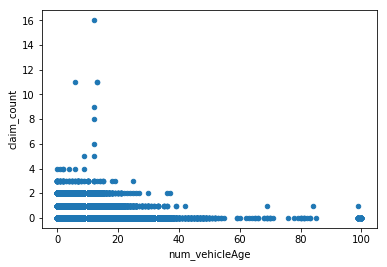

In [56]:
rawdata.plot(3,1,kind='scatter')

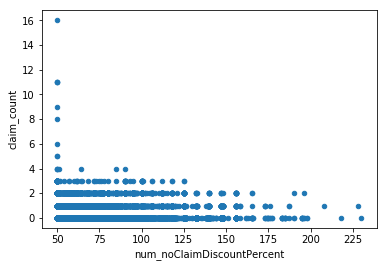

In [57]:
rawdata.plot(4,1,kind='scatter')

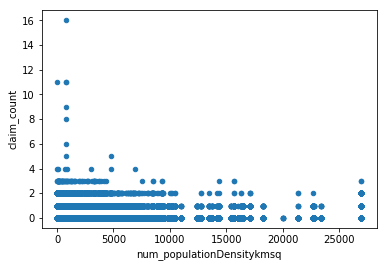

In [58]:
rawdata.plot(6,1,kind='scatter')

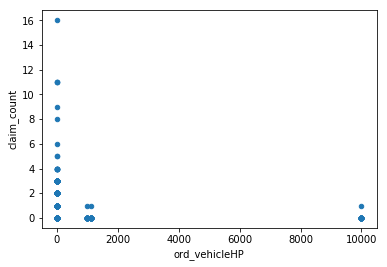

In [59]:
rawdata.plot(8,1,kind='scatter')

In [60]:
rawdata['ord_vehicleHP'].describe()

count    678013.000000
mean          6.948194
std          64.908621
min           4.000000
25%           5.000000
50%           6.000000
75%           7.000000
max        9999.000000
Name: ord_vehicleHP, dtype: float64

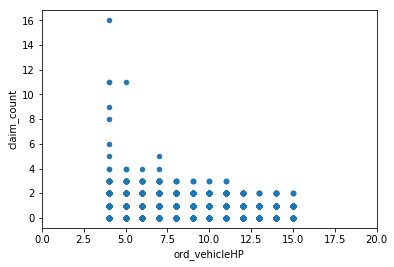

In [61]:
rawdata.plot(8,1,kind='scatter', xlim=[0,20])

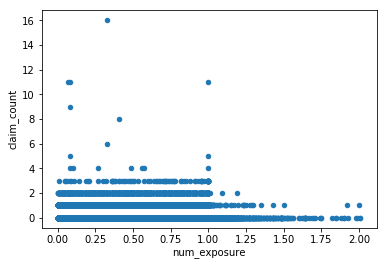

In [62]:
rawdata.plot(9,1,kind='scatter')

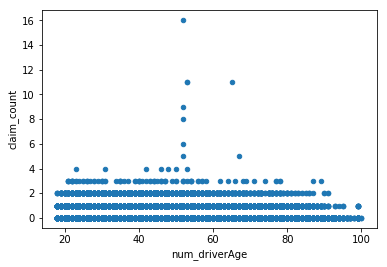

In [63]:
rawdata.plot(11,1,kind='scatter')

# Feature Engineering

## Convert categories into numeric risk factors based on average claim count for each class

In [64]:
areacode_analysis = rawdata.groupby('cat_areacode').agg({'claim_count':'mean'}).rename(columns={'claim_count':'areacode_risk'})

In [65]:
areacode_analysis.head(7)

,areacode_risk
cat_areacode,
A,0.048703
B,0.050358
C,0.051464
D,0.055595
E,0.056901
F,0.062994


In [66]:
carbrand_analysis = rawdata.groupby('cat_carBrand').agg({'claim_count':'mean'}).rename(columns={'claim_count':'carbrand_risk'})

In [67]:
carbrand_analysis.head(15)

,carbrand_risk
cat_carBrand,
B1,0.053319
B10,0.048455
B11,0.053073
B12,0.053360
B13,0.053293
B14,0.041018
B2,0.053547
B3,0.052776
B4,0.052107


In [68]:
region_analysis = rawdata.groupby('cat_Region').agg({'claim_count':'mean'}).rename(columns={'claim_count':'region_risk'})

In [69]:
region_analysis.head(50)

,region_risk
cat_Region,
R11,0.056999
R21,0.052875
R22,0.054916
R23,0.034495
R24,0.057310
R25,0.058111
R26,0.048704
R31,0.043101
R41,0.047036


In [70]:
fueltype_analysis = rawdata.groupby('cat_fuelType').agg({'claim_count':'mean'}).rename(columns={'claim_count':'fueltype_risk'})

In [71]:
fueltype_analysis.head()

,fueltype_risk
cat_fuelType,
Diesel,0.050120
Electric,0.200000
Regular,0.056243
Unknown,0.045455


In [72]:
engineered_data = pd.merge (rawdata, areacode_analysis, on='cat_areacode')
engineered_data = pd.merge (engineered_data, carbrand_analysis, on='cat_carBrand')
engineered_data = pd.merge (engineered_data, region_analysis, on='cat_Region')
engineered_data = pd.merge (engineered_data, fueltype_analysis, on = 'cat_fuelType')
features = engineered_data.drop(['cat_areacode', 'cat_Region', 'cat_carBrand','cat_fuelType'], axis=1)

In [73]:
features.head()

,policy_desc,claim_count,num_vehicleAge,num_noClaimDiscountPercent,num_populationDensitykmsq,ord_vehicleHP,num_exposure,num_driverAge,missing_exposure,missing_driverAge,areacode_risk,carbrand_risk,region_risk,fueltype_risk
0,1,1,0,50,1217,5,0.10,55,0,0,0.055595,0.05336,0.059373,0.056243
1,3,1,0,50,1217,5,0.77,55,0,0,0.055595,0.05336,0.059373,0.056243
2,731,1,9,90,745,8,0.12,23,0,0,0.055595,0.05336,0.059373,0.056243
3,732,2,9,90,745,8,0.21,23,0,0,0.055595,0.05336,0.059373,0.056243
4,1052,1,0,68,1871,10,0.08,58,0,0,0.055595,0.05336,0.059373,0.056243


## Check for dependencies between features

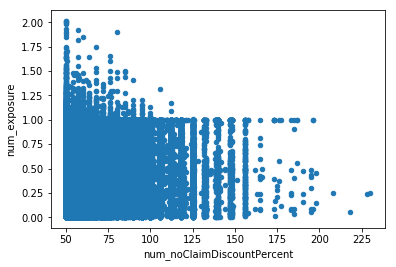

In [74]:
features.plot (3, 6, kind='scatter')

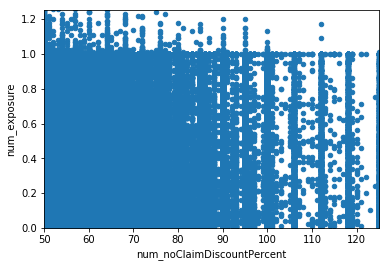

In [75]:
features.plot (3, 6, kind='scatter', xlim=[50,125], ylim=[0,1.25])

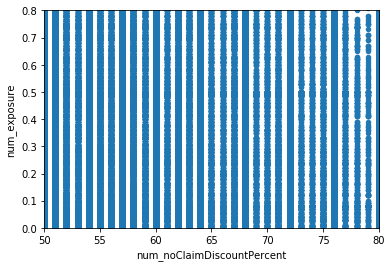

In [76]:
features.plot (3, 6, kind='scatter', xlim=[50,80], ylim=[0,0.8])

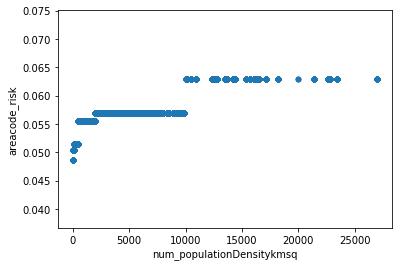

In [77]:
features.plot (4, 10, kind='scatter')

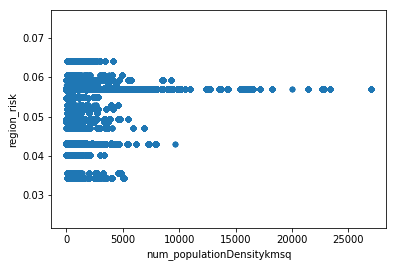

In [78]:
features.plot (4, 12, kind='scatter')

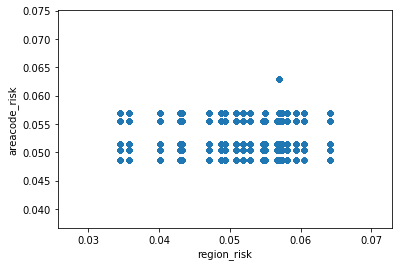

In [79]:
features.plot (12, 10, kind='scatter')

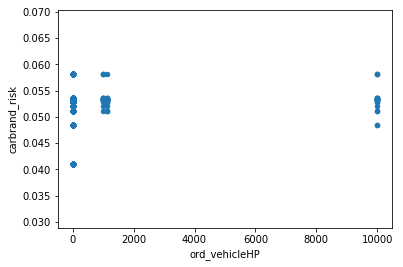

In [80]:
features.plot (5, 11, kind='scatter')

# Split into training and test sets

In [84]:
train_set, test_set = train_test_split(features,test_size=0.7)

In [85]:
train_set.head()

,policy_desc,claim_count,num_vehicleAge,num_noClaimDiscountPercent,num_populationDensitykmsq,ord_vehicleHP,num_exposure,num_driverAge,missing_exposure,missing_driverAge,areacode_risk,carbrand_risk,region_risk,fueltype_risk
300936,4119191,0,18,50,163,7,1.00,48,0,0,0.051464,0.052107,0.057310,0.056243
270735,2210392,0,11,50,44,8,0.96,45,0,0,0.048703,0.048455,0.057310,0.056243
571881,1020981,0,0,50,418,5,0.52,53,0,0,0.051464,0.053547,0.064147,0.050120
157227,2227773,0,7,72,3317,7,0.23,29,0,0,0.056901,0.051212,0.049259,0.056243
8304,4161666,0,18,50,156,9,0.49,36,0,0,0.051464,0.053360,0.059373,0.056243


In [86]:
test_set.head()

,policy_desc,claim_count,num_vehicleAge,num_noClaimDiscountPercent,num_populationDensitykmsq,ord_vehicleHP,num_exposure,num_driverAge,missing_exposure,missing_driverAge,areacode_risk,carbrand_risk,region_risk,fueltype_risk
561307,4130008,0,13,64,52,6,1.00,47,0,0,0.050358,0.053319,0.064147,0.050120
216002,3092966,0,16,51,169,4,0.84,45,0,0,0.051464,0.053547,0.051870,0.056243
288291,4115355,0,10,50,155,7,1.00,50,0,0,0.051464,0.053319,0.057310,0.056243
302396,3046407,0,7,50,1064,5,1.00,61,0,0,0.055595,0.052776,0.057310,0.056243
369566,3135314,0,1,50,398,11,1.00,37,0,0,0.051464,0.052776,0.059373,0.050120


In [87]:
train_labels = train_set[['claim_count']]

In [88]:
test_labels = test_set[['claim_count']]

In [89]:
train_features = train_set.drop(['claim_count','policy_desc'], axis=1)

In [90]:
test_features = test_set.drop(['claim_count','policy_desc'], axis=1)

In [91]:
train_features.head()

,num_vehicleAge,num_noClaimDiscountPercent,num_populationDensitykmsq,ord_vehicleHP,num_exposure,num_driverAge,missing_exposure,missing_driverAge,areacode_risk,carbrand_risk,region_risk,fueltype_risk
300936,18,50,163,7,1.00,48,0,0,0.051464,0.052107,0.057310,0.056243
270735,11,50,44,8,0.96,45,0,0,0.048703,0.048455,0.057310,0.056243
571881,0,50,418,5,0.52,53,0,0,0.051464,0.053547,0.064147,0.050120
157227,7,72,3317,7,0.23,29,0,0,0.056901,0.051212,0.049259,0.056243
8304,18,50,156,9,0.49,36,0,0,0.051464,0.053360,0.059373,0.056243


In [92]:
test_features.head()

,num_vehicleAge,num_noClaimDiscountPercent,num_populationDensitykmsq,ord_vehicleHP,num_exposure,num_driverAge,missing_exposure,missing_driverAge,areacode_risk,carbrand_risk,region_risk,fueltype_risk
561307,13,64,52,6,1.00,47,0,0,0.050358,0.053319,0.064147,0.050120
216002,16,51,169,4,0.84,45,0,0,0.051464,0.053547,0.051870,0.056243
288291,10,50,155,7,1.00,50,0,0,0.051464,0.053319,0.057310,0.056243
302396,7,50,1064,5,1.00,61,0,0,0.055595,0.052776,0.057310,0.056243
369566,1,50,398,11,1.00,37,0,0,0.051464,0.052776,0.059373,0.050120


# Ensemble Voting Regression using Random Forest and Gradient Boosting

In [93]:
gb = GradientBoostingRegressor(random_state=1, n_estimators=700, max_depth=5, min_samples_leaf=3, subsample=0.5)
rf = RandomForestRegressor(random_state=4, n_estimators=700, max_depth=5, min_samples_leaf=3)

In [94]:
gb.fit (train_features, np.ravel(train_labels))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=700,
                          n_iter_no_change=None, presort='auto', random_state=1,
                          subsample=0.5, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [95]:
rf.fit (train_features, np.ravel(train_labels))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=700,
                      n_jobs=None, oob_score=False, random_state=4, verbose=0,
                      warm_start=False)

In [96]:
voting = VotingRegressor(estimators=[('gb', gb), ('rf', rf)])

In [97]:
gb_test_predictions = gb.predict(test_features)

In [98]:
gb_test_score = gb.score (test_features, test_labels)

In [99]:
print (gb_test_score)

0.0233675020541384


In [100]:
rf_test_predictions = rf.predict(test_features)

In [101]:
rf_test_score = rf.score (test_features, test_labels)

In [102]:
print (rf_test_score)

0.027494775356115667


In [103]:
voting.fit (train_features, np.ravel(train_labels))

VotingRegressor(estimators=[('gb',
                             GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=5,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=3,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                   

In [104]:
test_predictions = voting.predict(test_features)

# Validation of Predictions (compare metrics with a baseline prediction)

In [105]:
test_score = voting.score (test_features, test_labels)

In [106]:
print (test_score)

0.033753116222790314


In [107]:
dummy = DummyRegressor(strategy="median") # baseline non-prediction is to use the median value of claim count

In [108]:
dummy.fit (train_features, np.ravel(train_labels))

DummyRegressor(constant=None, quantile=None, strategy='median')

In [109]:
dummy_predictions = dummy.predict(test_features)

In [110]:
model_explained_variance = explained_variance_score (test_labels, test_predictions)

In [111]:
print (model_explained_variance)

0.0337559150180593


In [112]:
print (explained_variance_score (test_labels, gb_test_predictions))

0.023374493764813375


In [113]:
print (explained_variance_score (test_labels, rf_test_predictions))

0.027495267789181654


In [114]:
baseline_explained_variance = explained_variance_score (test_labels, dummy_predictions)

In [115]:
print (baseline_explained_variance)

0.0


In [116]:
explained_variance_improvement = model_explained_variance - baseline_explained_variance

In [117]:
print (explained_variance_improvement)

0.0337559150180593


In [119]:
model_score = r2_score (test_labels, test_predictions)

In [120]:
print (model_score)

0.033753116222790314


In [121]:
print (r2_score (test_labels, gb_test_predictions))

0.0233675020541384


In [122]:
print (r2_score (test_labels, rf_test_predictions))

0.027494775356115664


In [123]:
baseline_score = r2_score (test_labels, dummy_predictions)

In [124]:
print (baseline_score)

-0.04923768791659522


In [125]:
score_improvement = model_score - baseline_score

In [126]:
print (score_improvement)

0.08299080413938553
